# Homework 5: Predict Time Series
Applied Neural Networks

Tyler Kness-Miller

Explanation at Bottom of Notebook.

**Part 1**</br>
Generate a time series dataset (10000 series with 100 points each). Build these from two sine waves and noise, similar to what we did in class, HOWEVER instead of adding the two sine waves together you will MULTIPLY them, each weighted the same (and then add noise). This will create an oscillating signal of the shorter wavelength sine with an overlaid oscillating "envelope" from the larger wavelength sine. <br/>
Graph several example series.

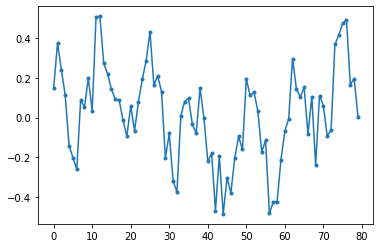

In [1]:
# Standard import statements
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

time = np.arange(0, 4*np.pi, 0.1)
sine = np.sin(time)
sine2 = np.sin(5*time + 0.5*np.pi)

noise = np.random.random(len(time))
noise = 2 * noise - 1

signal = 0.2 * sine + 0.2 * sine2 + 0.2 * noise

#plt.plot(signal)
plt.plot(signal[:80], marker='o', markersize=3)

def make_waves(n):
  data = np.empty( (n, 126) )
  for i in range(n):
    # Dominant wave
    freq = np.random.uniform(0.2, 5)
    offset = np.random.uniform(-1, 1)
    sine = np.sin(freq*time + offset*np.pi)
    # Secondary wave
    freq = np.random.uniform(0.2, 5)
    offset = np.random.uniform(-1, 1)
    sine2 = np.sin(freq*time + offset*np.pi)
    # Noise
    noise = np.random.random(len(time))
    noise = 2*noise - 1
    # Total signal
    signal = 0.2*sine + 0.2*sine2 + 0.2*noise
    data[i,:] = signal
  return data

def plot_pred(y_pred, y_true, signal):
  plt.plot(signal, marker='o', markersize=3)  # training data, first 85 points
  plt.plot(len(signal)+1, y_pred, marker='s')  # predicted 86th point
  plt.plot(len(signal)+1, y_true, marker='o', markersize=5, c='red')  # actual 86th point
  plt.show()

#Generate the dataset. 
dataset = make_waves(10000)
X_train = dataset[:7000, :80] # use first 7000 waves for training, first 80 points
X_train.shape
y_train = dataset[:7000, 80] # 81st point --> what we are trying to predict
X_valid = dataset[7000:9000, :80]
y_valid = dataset[7000:9000, 80]
X_test = dataset[9000:, :80]
y_test = dataset[9000:, 80]

In [17]:
keras.backend.clear_session()

In [15]:
#Only run once...
X_train = np.expand_dims(X_train, axis=-1)
X_valid = np.expand_dims(X_valid, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train.shape

(7000, 80, 1)

**Part 2** </br>
Predict the 81st point.<br/>
Use the first 80 points for training. Create training, validation, and testing sets. Utilize an RNN (obviously).</br>
Give your testing and validation accuracies, and graph a couple series (including prediction and actual 81st points).


Epoch 1/100
219/219 [==============================] - 15s 54ms/step - loss: 0.1083 - val_loss: 0.0317
Epoch 2/100
219/219 [==============================] - 11s 50ms/step - loss: 0.0270 - val_loss: 0.0245
Epoch 3/100
219/219 [==============================] - 11s 49ms/step - loss: 0.0263 - val_loss: 0.0315
Epoch 4/100
219/219 [==============================] - 11s 50ms/step - loss: 0.0253 - val_loss: 0.0246
Epoch 5/100
219/219 [==============================] - 11s 49ms/step - loss: 0.0241 - val_loss: 0.0226
Epoch 6/100
219/219 [==============================] - 11s 49ms/step - loss: 0.0225 - val_loss: 0.0239
Epoch 7/100
219/219 [==============================] - 11s 49ms/step - loss: 0.0226 - val_loss: 0.0230
Epoch 8/100
219/219 [==============================] - 11s 49ms/step - loss: 0.0228 - val_loss: 0.0224
Epoch 9/100
219/219 [==============================] - 11s 49ms/step - loss: 0.0228 - val_loss: 0.0227
Epoch 10/100
219/219 [==============================] - 11s 50ms/step - l

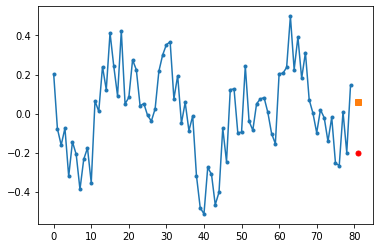

In [18]:
model = keras.models.Sequential([
              keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]), # 20 neurons, default tanh activation
              keras.layers.SimpleRNN(20, return_sequences=True),
              keras.layers.SimpleRNN(20, return_sequences=True),
              keras.layers.SimpleRNN(1)
])

optimizer = keras.optimizers.Nadam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=100, 
                    validation_data = (X_valid, y_valid), 
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

model.evaluate(X_test, y_test)
model.evaluate(X_valid, y_valid)

y_pred = model.predict(X_train)

wave = 2
plot_pred(y_pred[wave], y_train[wave], X_train[wave])

**Part 3** </br>
Predict the 81-90th points.</br>
Use the first 80 points for training. Create training, validation, and testing sets. Create at least one sequence-to-vector RNN and one sequence-to-sequence RNN and compare their results.<br/>
Give your testing and validation accuracies, and graph a couple series (including prediction and actual 81-90th points) for both RNNs.

In [19]:
#Modify copy of dataset to include 10 points to be predicted. 
num_predictions = 10
Y_train = dataset[:7000, 80:80+num_predictions]
Y_valid = dataset[7000:9000, 80:80+num_predictions]
Y_test = dataset[9000:, 80:80+num_predictions]
Y_train.shape

(7000, 10)

In [20]:
keras.backend.clear_session()

In [21]:
#Sequence-to-Vector RNN
model = keras.models.Sequential([
              keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
              keras.layers.SimpleRNN(20, return_sequences=True),
              keras.layers.SimpleRNN(20),
              keras.layers.Dense(num_predictions)
])

optimizer = keras.optimizers.Nadam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, Y_train, epochs=100,
                    validation_data = (X_valid, Y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/100
219/219 [==============================] - 11s 40ms/step - loss: 0.0774 - val_loss: 0.0456
Epoch 2/100
219/219 [==============================] - 8s 37ms/step - loss: 0.0431 - val_loss: 0.0421
Epoch 3/100
219/219 [==============================] - 8s 38ms/step - loss: 0.0421 - val_loss: 0.0419
Epoch 4/100
219/219 [==============================] - 8s 39ms/step - loss: 0.0427 - val_loss: 0.0406
Epoch 5/100
219/219 [==============================] - 8s 39ms/step - loss: 0.0410 - val_loss: 0.0402
Epoch 6/100
219/219 [==============================] - 9s 39ms/step - loss: 0.0410 - val_loss: 0.0494
Epoch 7/100
219/219 [==============================] - 8s 38ms/step - loss: 0.0417 - val_loss: 0.0416
Epoch 8/100
219/219 [==============================] - 8s 38ms/step - loss: 0.0410 - val_loss: 0.0407
Epoch 9/100
219/219 [==============================] - 9s 39ms/step - loss: 0.0414 - val_loss: 0.0422
Epoch 10/100
219/219 [==============================] - 8s 38ms/step - loss: 0.04

63/63 [==============================] - 1s 10ms/step - loss: 0.0410


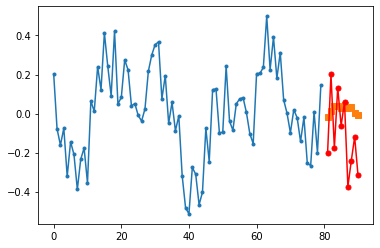

In [22]:
model.evaluate(X_test, Y_test)
model.evaluate(X_valid, Y_valid)

Y_pred = model.predict(X_train)
def plot_vector_pred(Y_pred, Y_true, signal):
  plt.plot(signal, marker='o', markersize=3)  # training data, first 85 points
  start = len(signal) + 1
  plt.plot(np.arange(start, start+num_predictions), Y_pred, marker='s')  # predicted points
  plt.plot(np.arange(start, start+num_predictions), Y_true, marker='o', markersize=5, c='red')  # actual points
  plt.show()

wave = 2
plot_vector_pred(Y_pred[wave], Y_train[wave], X_train[wave])

In [23]:
#Sequence-to-Sequence RNN
num_predictions = 10
num_steps = 80
Y = np.empty( (10000, num_steps, num_predictions) )
for i in range(num_steps):
  Y[:, i, :] = dataset[:, i+1:i+num_predictions+1]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]
Y.shape

model = keras.models.Sequential([
              keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]), 
              keras.layers.SimpleRNN(20, return_sequences=True),
              keras.layers.SimpleRNN(20, return_sequences=True),
              keras.layers.TimeDistributed(keras.layers.Dense(num_predictions)) 
])

def last_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Nadam(lr=0.01)  
model.compile(loss="mse", optimizer=optimizer, metrics=[last_mse])
history = model.fit(X_train, Y_train, epochs=100,
                    validation_data = (X_valid, Y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/100
219/219 [==============================] - 12s 42ms/step - loss: 0.0629 - last_mse: 0.0647 - val_loss: 0.0415 - val_last_mse: 0.0401
Epoch 2/100
219/219 [==============================] - 9s 39ms/step - loss: 0.0411 - last_mse: 0.0403 - val_loss: 0.0407 - val_last_mse: 0.0393
Epoch 3/100
219/219 [==============================] - 9s 40ms/step - loss: 0.0405 - last_mse: 0.0395 - val_loss: 0.0446 - val_last_mse: 0.0445
Epoch 4/100
219/219 [==============================] - 9s 40ms/step - loss: 0.0405 - last_mse: 0.0400 - val_loss: 0.0409 - val_last_mse: 0.0391
Epoch 5/100
219/219 [==============================] - 9s 40ms/step - loss: 0.0401 - last_mse: 0.0390 - val_loss: 0.0408 - val_last_mse: 0.0390
Epoch 6/100
219/219 [==============================] - 9s 40ms/step - loss: 0.0398 - last_mse: 0.0388 - val_loss: 0.0402 - val_last_mse: 0.0380
Epoch 7/100
219/219 [==============================] - 9s 40ms/step - loss: 0.0395 - last_mse: 0.0381 - val_loss: 0.0443 - val_last_mse

63/63 [==============================] - 1s 10ms/step - loss: 0.0394 - last_mse: 0.0375


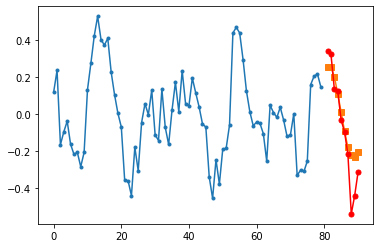

In [24]:
model.evaluate(X_test, Y_test)
model.evaluate(X_valid, Y_valid)

Y_pred = model.predict(X_train)

wave = 1
plot_vector_pred(Y_pred[wave, -1], Y_train[wave, -1], X_train[wave])

**Part 4**</br>
Discuss your findings.

MSE Defined as Follows: (Test_MSE / Valid_MSE)

Simple, Dense RNN MSE: 0.0208 / 0.0224

Sequence-to-Vector RNN MSE: 0.0413 / 0.0410

Sequence-to-Sequence RNN MSE: 0.0374 / 0.0375

The Simple, Dense RNN surprisingly had the lowest MSE compared to the two other RNNs that I ran. When plotting the predicted points on the sequence-to-sequence RNN, I noticed that it didn't keep the original pattern of the wave, or at least didn't seem to, choosing to instead keep a downward slope. 

The sequence-to-vector RNN at least tried to keep the shape of the wave as it predicted the future 10 points of the time series. 

Overall, the results surprised me, but were intriguing nonetheless.